In [1]:
# Library
import pathlib
import tensorflow as tf
import datetime

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, experimental, BatchNormalization


In [2]:
%load_ext tensorboard

# Definition and Training

In [3]:
data_dir = pathlib.Path('Dataset')


In [4]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


8982


In [5]:
batch_size = 32
img_height = 128
img_width = 128
Image_Size = (img_width, img_height)


In [6]:
train = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=69,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical")


Found 8982 files belonging to 3 classes.
Using 7186 files for training.


2022-01-09 10:26:34.298235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:26:34.381843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:26:34.382601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:26:34.385795: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
test = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=69,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical")


Found 8982 files belonging to 3 classes.
Using 1796 files for validation.


In [8]:
class_names = train.class_names
print(class_names)


['mask_weared_incorrect', 'with_mask', 'without_mask']


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)


In [10]:
input_shapes = (128, 128, 3)


In [11]:
model = Sequential()

model.add(experimental.preprocessing.Rescaling(
    1/255, input_shape=(input_shapes)))

model.add(Conv2D(32, (3, 3), activation=keras.activations.relu,
          input_shape=input_shapes))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation=keras.activations.relu))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=keras.activations.relu))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation=keras.activations.relu))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation=keras.activations.softmax))


In [12]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=3, mode="min")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)


2022-01-09 10:26:38.304195: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-09 10:26:38.304242: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-09 10:26:38.306412: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-09 10:26:38.520543: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-09 10:26:38.520726: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [13]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        2

In [15]:
history = model.fit(train, epochs=15, validation_data=test,
                    callbacks=[early_stopping, tensorboard_callback])


Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '
2022-01-09 10:26:39.914664: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-09 10:26:41.506889: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/225 [..............................] - ETA: 29:24 - loss: 1.8643 - accuracy: 0.4688 - precision: 0.4483 - recall: 0.4062

2022-01-09 10:26:46.786364: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-09 10:26:46.786409: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/225 [..............................] - ETA: 1:11 - loss: 1.3758 - accuracy: 0.6406 - precision: 0.6393 - recall: 0.6094 

2022-01-09 10:26:47.076500: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-09 10:26:47.076970: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-09 10:26:47.209258: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 254 callback api events and 249 activity events. 
2022-01-09 10:26:47.219303: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-09 10:26:47.236434: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20220109-102638/train/plugins/profile/2022_01_09_10_26_47

2022-01-09 10:26:47.243425: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20220109-102638/train/plugins/profile/2022_01_09_10_26_47/1b4c8c4c3c01.trace.json.gz
2022-01-09 10:26:47.265690: I tensorflow/core/profiler/rpc/client/save_profile.cc:

225/225 [==============================] - 27s 85ms/step - loss: 0.3808 - accuracy: 0.8727 - precision: 0.8786 - recall: 0.8664 - val_loss: 3.5981 - val_accuracy: 0.5729 - val_precision: 0.5729 - val_recall: 0.5729
Epoch 2/15
225/225 [==============================] - 4s 17ms/step - loss: 0.2218 - accuracy: 0.9228 - precision: 0.9262 - recall: 0.9169 - val_loss: 2.1024 - val_accuracy: 0.6264 - val_precision: 0.6295 - val_recall: 0.6264
Epoch 3/15
225/225 [==============================] - 4s 17ms/step - loss: 0.2146 - accuracy: 0.9217 - precision: 0.9255 - recall: 0.9168 - val_loss: 0.1893 - val_accuracy: 0.9337 - val_precision: 0.9408 - val_recall: 0.9298
Epoch 4/15
225/225 [==============================] - 4s 17ms/step - loss: 0.1264 - accuracy: 0.9578 - precision: 0.9600 - recall: 0.9549 - val_loss: 0.1557 - val_accuracy: 0.9488 - val_precision: 0.9513 - val_recall: 0.9471
Epoch 5/15
225/225 [==============================] - 4s 18ms/step - loss: 0.1043 - accuracy: 0.9652 - precisi

In [16]:
model.save('mask_detection_model.h5')

# Evaluation

In [17]:
model = keras.models.load_model('mask_detection_model.h5')


In [18]:
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model


In [19]:
def plot_curve(metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(metric)
    plt.show()

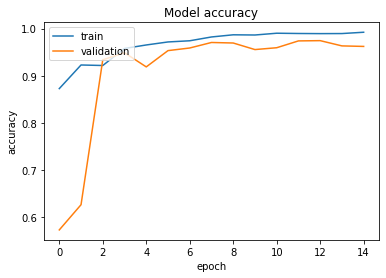

In [20]:
plot_curve('accuracy')

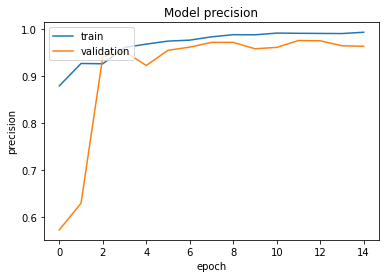

In [21]:
plot_curve('precision')

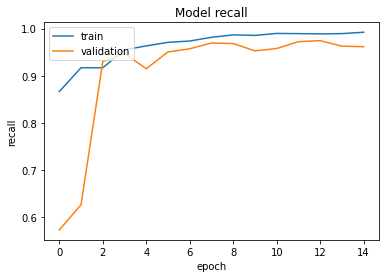

In [22]:
plot_curve('recall')

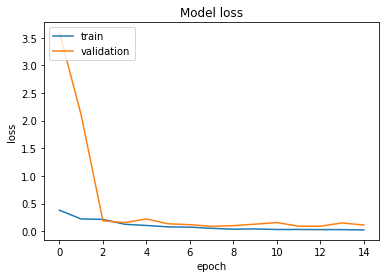

In [23]:
plot_curve('loss')

In [24]:
model.evaluate(test, return_dict=True)


57/57 [==============================] - 1s 7ms/step - loss: 0.1122 - accuracy: 0.9621 - precision: 0.9627 - recall: 0.9616


{'loss': 0.11223748326301575,
 'accuracy': 0.9621380567550659,
 'precision': 0.9626532793045044,
 'recall': 0.961581289768219}